# Tidy Data

"Tidy Data" is a phrase used to describe data that is organized to facilitate analysis and modeling.

The phrase was coined by Hadley Wickham in a paper here:  http://vita.had.co.nz/papers/tidy-data.pdf

See here for the paper and example data: https://www.jstatsoft.org/article/view/v059i10/

The book <u>Pandes for Everyone:  Python Data Analysis</u> by Daniel Chen has a good chapter on "tidy data" and some of the examples here are adapted from that book.

More examples here: 
- https://towardsdatascience.com/whats-tidy-data-how-to-organize-messy-datasets-in-python-with-melt-and-pivotable-functions-5d52daa996c9
- http://www.jeannicholashould.com/tidy-data-in-python.html
- https://www.datasciencecentral.com/tidy-data-in-python/
- https://github.com/nickhould/tidy-data-python

From a machine learning perspective, consider describing observation vectors, features, and labels.  Observation vectors directly map to rows (index) in a DataFrame.  Features and labels correspond to specific columns.

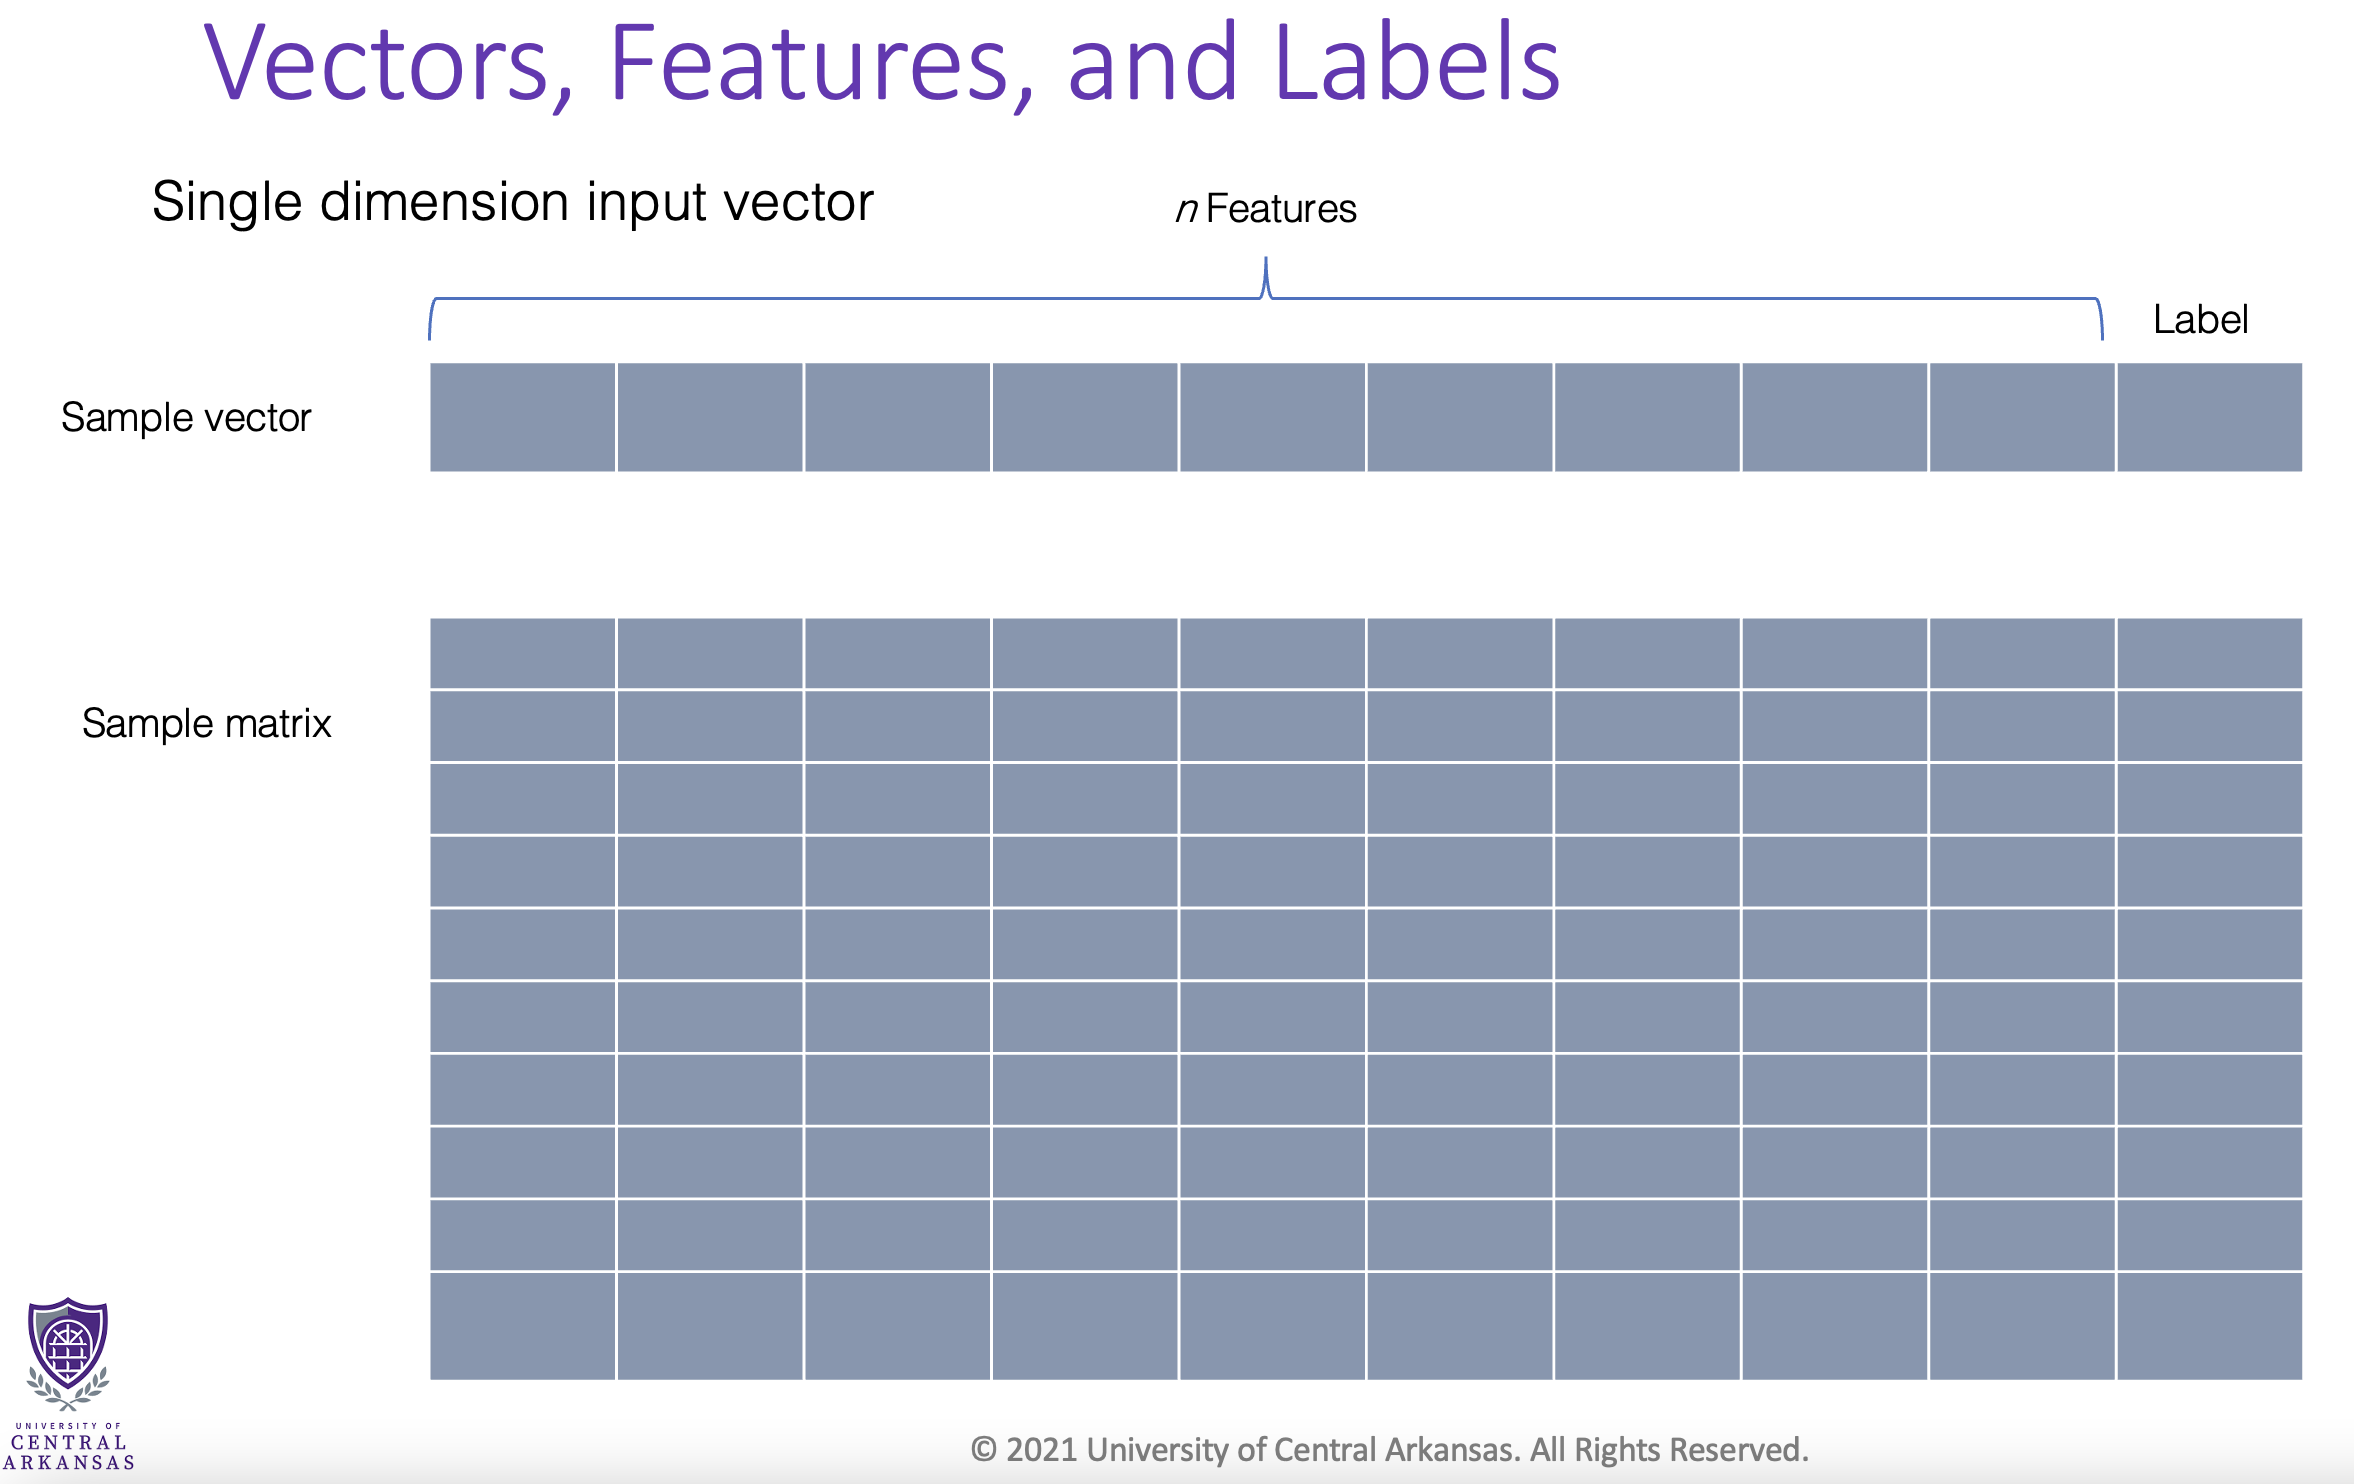

The criteria for "tidy data" is summarized by:

- Each row is an observation
- Each column is a variable
- Each type of observational unit forms a distinct table

The concept of "tidy data" is similar to normalization in relational databases (in particular, 3rd normal form) with a particular focus on observational data.  This is particularly true for the criteria that each type of observational unit is a separate table.  This often implies that multiple tables must be combined to construct a complete set of data for analysis and modeling.

The "tidy data" criteria that each row is an observation and each column is a variable often requires data to be rearranged.

In particular, it is sometimes the case that rows contain columns that describe variables along with other columns that give the associated value.  For tidy data, we need columns to contain ***values*** not ***variables***, so we may need to reorganize the data to meet that criteria.

All tables are defined by rows and columns, but the semantics of the rows and columns are not inherently described.  

This is one of the points about "tidy data" because the semantics associated with rows are ***observations***, the semantics associated with columns are ***variables***, and each value describes the underlying attribute (e.g., size, quantity, temperature, etc.) of a particular combination of observation and variable.

Some variables (and their values) are known at the time of the experiment or data collection.  These are referred to as ***fixed variables*** or ***dimensions***.  Other variables are measured at the time of the experiment (or at data collection).  These variables are referred to as ***measured variables***.  The recommendation for "tidy data" is that fixed variables appear first (as the leftmost columns) and measured variables appear after (as the rightmost columns).  There is no technical reason for this ordering, but the intent of the "tidy data" philosophy is to ease the understanding and use of data by following conventions in organizing the data.

Deciding when columns represent multiple attributes (i.e., are distinct variables) of a single observation or represent a single ***variable*** over multiple observations can be challenging and somewhat dependent upon the context of the experiment, the data, and the problem to be solved.

However, there are several types of problems with data organization that are common in practice.  In this notebook, we'll look at several of these situations and illustrate how to address those problems. 

Common problems with "messy data":

- [Column headers are values, not variable names](#Column-headers-are-values,-not-variable-names)
- [Multiple variables are stored in one column](#Multiple-Variables-Stored-in-One-Column)
- [Variables are stored in both rows and columns](#Variables-are-stored-in-both-rows-and-columns)
- [A single observational unit is stored in multiple tables](#A-single-observational-unit-is-stored-in-multiple-tables)

Below, we consider examples of each of these common problems and how we might address the problem.

In [1]:
import os
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

import glob
import re

# Column headers are values, not variable names

It is common for data to have columns that represent different values of a common variable.  This is particularly true of data that is organized to be presented to an audience.

Consider the following data from the Pew Research Institute on members of particular religions and their incomes.

First, where are we in the file system?

In [2]:
pwd

'c:\\Users\\addis\\Documents\\Introduction to Data Science\\Tidy Data'

Now, build the path to the data file folder relative to our current working directory.

In [3]:
# Set the path to our data location
# datapath = os.path.join('./wickham_tidy_data', '')
datapath = os.path.join('.', '')
datapath

'.\\'

Take a look at all the CSV files available for our examples.

In [4]:
!ls {datapath + '*.csv'}

'ls' is not recognized as an internal or external command,
operable program or batch file.


Add the specific data file name to the path and read the data into a dataframe.

In [5]:
pew = pd.read_csv(datapath + 'pew.csv')

In [6]:
pew

,religion,<$10k,$10-20k,$20-30k,$30-40k,$40-50k,$50-75k,$75-100k,$100-150k,>150k,Don't know/refused
0,Agnostic,27,34,60,81,76,137,122,109,84,96
1,Atheist,12,27,37,52,35,70,73,59,74,76
2,Buddhist,27,21,30,34,33,58,62,39,53,54
3,Catholic,418,617,732,670,638,1116,949,792,633,1489
4,Don’t know/refused,15,14,15,11,10,35,21,17,18,116
5,Evangelical Prot,575,869,1064,982,881,1486,949,723,414,1529
6,Hindu,1,9,7,9,11,34,47,48,54,37
7,Historically Black Prot,228,244,236,238,197,223,131,81,78,339
8,Jehovah's Witness,20,27,24,24,21,30,15,11,6,37
9,Jewish,19,19,25,25,30,95,69,87,151,162


All of the columns except for ***religion*** represent a particular range of values for family income.  Put another way, all of these columns represent different values of a particular variable, ***income***.

Pandas has a method `melt` specifically for converting this type of situation.  In the call below, `id_vars` contains a list of all columns ***not*** to consider a single variable.

In essence, we are creating rows in the new table by creating a new row from each existing column for each of the income subrange columns.

There are 18 current rows and 10 columns with income subrange values, so we should end up with 180 rows.  What happens when we `melt` the original table?

In [7]:
pew_tidy = pd.melt(pew, id_vars='religion')

In [8]:
pew_tidy

,religion,variable,value
0,Agnostic,<$10k,27
1,Atheist,<$10k,12
2,Buddhist,<$10k,27
3,Catholic,<$10k,418
4,Don’t know/refused,<$10k,15
...,...,...,...
175,Orthodox,Don't know/refused,73
176,Other Christian,Don't know/refused,18
177,Other Faiths,Don't know/refused,71
178,Other World Religions,Don't know/refused,8


We can name the new variable to ***income*** and the value to be the ***count*** observed during data collection.

In [9]:
pew_tidy = pd.melt(pew, id_vars='religion', var_name='income', value_name='count')
pew_tidy

,religion,income,count
0,Agnostic,<$10k,27
1,Atheist,<$10k,12
2,Buddhist,<$10k,27
3,Catholic,<$10k,418
4,Don’t know/refused,<$10k,15
...,...,...,...
175,Orthodox,Don't know/refused,73
176,Other Christian,Don't know/refused,18
177,Other Faiths,Don't know/refused,71
178,Other World Religions,Don't know/refused,8


On a side note, if we need to recreate the original data format, we can perform that operation from the "long" format by producing a pivot table.

In [10]:
pew_pivot = pew_tidy.pivot_table(index = 'religion', columns = 'income', values = 'count') \
.reset_index().rename_axis(None, axis='columns')

In [11]:
pew_pivot

,religion,$10-20k,$100-150k,$20-30k,$30-40k,$40-50k,$50-75k,$75-100k,<$10k,>150k,Don't know/refused
0,Agnostic,34.0,109.0,60.0,81.0,76.0,137.0,122.0,27.0,84.0,96.0
1,Atheist,27.0,59.0,37.0,52.0,35.0,70.0,73.0,12.0,74.0,76.0
2,Buddhist,21.0,39.0,30.0,34.0,33.0,58.0,62.0,27.0,53.0,54.0
3,Catholic,617.0,792.0,732.0,670.0,638.0,1116.0,949.0,418.0,633.0,1489.0
4,Don’t know/refused,14.0,17.0,15.0,11.0,10.0,35.0,21.0,15.0,18.0,116.0
5,Evangelical Prot,869.0,723.0,1064.0,982.0,881.0,1486.0,949.0,575.0,414.0,1529.0
6,Hindu,9.0,48.0,7.0,9.0,11.0,34.0,47.0,1.0,54.0,37.0
7,Historically Black Prot,244.0,81.0,236.0,238.0,197.0,223.0,131.0,228.0,78.0,339.0
8,Jehovah's Witness,27.0,11.0,24.0,24.0,21.0,30.0,15.0,20.0,6.0,37.0
9,Jewish,19.0,87.0,25.0,25.0,30.0,95.0,69.0,19.0,151.0,162.0


---

Here is another example where column names are values rather than variables.

In this case, the data comes from Billboard about music ratings of particular songs across multiple weeks.

In [12]:
billboard = pd.read_csv(datapath + 'billboard.csv', encoding="mac_latin2")

In [13]:
billboard

,year,artist.inverted,track,time,genre,date.entered,date.peaked,x1st.week,x2nd.week,x3rd.week,...,x67th.week,x68th.week,x69th.week,x70th.week,x71st.week,x72nd.week,x73rd.week,x74th.week,x75th.week,x76th.week
0,2000,Destiny's Child,Independent Women Part I,3:38,Rock,2000-09-23,2000-11-18,78,63.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,Santana,"Maria, Maria",4:18,Rock,2000-02-12,2000-04-08,15,8.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,Savage Garden,I Knew I Loved You,4:07,Rock,1999-10-23,2000-01-29,71,48.0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,Madonna,Music,3:45,Rock,2000-08-12,2000-09-16,41,23.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,"Aguilera, Christina",Come On Over Baby (All I Want Is You),3:38,Rock,2000-08-05,2000-10-14,57,47.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,2000,Ghostface Killah,Cherchez LaGhost,3:04,R&B,2000-08-05,2000-08-05,98,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313,2000,"Smith, Will",Freakin' It,3:58,Rap,2000-02-12,2000-02-12,99,99.0,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
314,2000,Zombie Nation,Kernkraft 400,3:30,Rock,2000-09-02,2000-09-02,99,99.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315,2000,"Eastsidaz, The",Got Beef,3:58,Rap,2000-07-01,2000-07-01,99,99.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Note that there are lots of weeks listed as columns.  This may have been a very convenient (and reasonable) way to collect the data, but we want to structure the data for analysis so the specific week value can be used as a variable, so we need to melt the weeks.

List all the variables to ***skip*** during the `melt`.

In [14]:
id_vars = ["year",
           "artist.inverted",
           "track",
           "time",
           "genre",
           "date.entered",
           "date.peaked"]

Do the melt, renaming the variable ***week*** and the values to ***rating***.

In [15]:
billboard_tidy = pd.melt(billboard, id_vars=id_vars, var_name='week', value_name='rating')

In [16]:
billboard_tidy

,year,artist.inverted,track,time,genre,date.entered,date.peaked,week,rating
0,2000,Destiny's Child,Independent Women Part I,3:38,Rock,2000-09-23,2000-11-18,x1st.week,78.0
1,2000,Santana,"Maria, Maria",4:18,Rock,2000-02-12,2000-04-08,x1st.week,15.0
2,2000,Savage Garden,I Knew I Loved You,4:07,Rock,1999-10-23,2000-01-29,x1st.week,71.0
3,2000,Madonna,Music,3:45,Rock,2000-08-12,2000-09-16,x1st.week,41.0
4,2000,"Aguilera, Christina",Come On Over Baby (All I Want Is You),3:38,Rock,2000-08-05,2000-10-14,x1st.week,57.0
...,...,...,...,...,...,...,...,...,...
24087,2000,Ghostface Killah,Cherchez LaGhost,3:04,R&B,2000-08-05,2000-08-05,x76th.week,NaN
24088,2000,"Smith, Will",Freakin' It,3:58,Rap,2000-02-12,2000-02-12,x76th.week,NaN
24089,2000,Zombie Nation,Kernkraft 400,3:30,Rock,2000-09-02,2000-09-02,x76th.week,NaN
24090,2000,"Eastsidaz, The",Got Beef,3:58,Rap,2000-07-01,2000-07-01,x76th.week,NaN


---

## Multiple Variables Stored in One Column

We have some data about tuberculosis ("TB") cases in a number of countries over several years.

Let's look at the data.

In [17]:
tb = pd.read_csv(datapath + 'tb.csv')

In [18]:
tb

,iso2,year,new_sp,new_sp_m04,new_sp_m514,new_sp_m014,new_sp_m1524,new_sp_m2534,new_sp_m3544,new_sp_m4554,...,new_sp_f04,new_sp_f514,new_sp_f014,new_sp_f1524,new_sp_f2534,new_sp_f3544,new_sp_f4554,new_sp_f5564,new_sp_f65,new_sp_fu
0,AD,1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AD,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AD,1991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AD,1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AD,1993,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5764,ZW,2004,14581.0,NaN,NaN,187.0,833.0,2908.0,2298.0,1056.0,...,NaN,NaN,225.0,1140.0,2858.0,1565.0,622.0,214.0,111.0,NaN
5765,ZW,2005,13155.0,NaN,NaN,210.0,837.0,2264.0,1855.0,762.0,...,NaN,NaN,269.0,1136.0,2242.0,1255.0,578.0,193.0,603.0,NaN
5766,ZW,2006,12718.0,NaN,NaN,215.0,736.0,2391.0,1939.0,896.0,...,NaN,NaN,237.0,1020.0,2424.0,1355.0,632.0,230.0,96.0,NaN
5767,ZW,2007,10583.0,6.0,132.0,138.0,500.0,3693.0,0.0,716.0,...,7.0,178.0,185.0,739.0,3311.0,0.0,553.0,213.0,90.0,NaN


The column names in the original data contain an encoding of the sex and age range of the case counts.  In other words, the values for two distinct variables (sex and age) are encoded in a single column name.

Let's 'melt' all the encoded columns into new columns for the encoding and the number of cases.

In [19]:
tb_long = pd.melt(tb, id_vars=["iso2", "year"], value_name="cases", var_name="sex_and_age")
tb_long

,iso2,year,sex_and_age,cases
0,AD,1989,new_sp,NaN
1,AD,1990,new_sp,NaN
2,AD,1991,new_sp,NaN
3,AD,1992,new_sp,NaN
4,AD,1993,new_sp,15.0
...,...,...,...,...
121144,ZW,2004,new_sp_fu,NaN
121145,ZW,2005,new_sp_fu,NaN
121146,ZW,2006,new_sp_fu,NaN
121147,ZW,2007,new_sp_fu,NaN


Now we have the sex and age encoding value in a column.  We can sample the table to see some of the encoding examples.

In [20]:
tb_long.sample(20)

,iso2,year,sex_and_age,cases
116306,CD,2006,new_sp_fu,NaN
116216,BY,2003,new_sp_fu,NaN
68560,TM,1981,new_sp_f04,NaN
44310,NR,1999,new_sp_m4554,1.0
6738,CG,1994,new_sp_m04,NaN
70776,EE,2008,new_sp_f514,0.0
34692,AG,1989,new_sp_m3544,NaN
15569,PA,1989,new_sp_m514,NaN
89555,LS,2005,new_sp_f2534,721.0
31622,KW,1982,new_sp_m2534,NaN


Many of our rows have no value (NaN) for the number of cases (note that is is distinct from having 0 cases). We will drop the rows where no data was collected.

In [21]:
tb_long = tb_long.dropna()
tb_long

,iso2,year,sex_and_age,cases
4,AD,1993,new_sp,15.0
5,AD,1994,new_sp,24.0
6,AD,1996,new_sp,8.0
7,AD,1997,new_sp,17.0
8,AD,1998,new_sp,1.0
...,...,...,...,...
120964,VU,2008,new_sp_fu,0.0
121038,YE,2008,new_sp_fu,0.0
121092,ZA,2008,new_sp_fu,0.0
121119,ZM,2008,new_sp_fu,0.0


In [22]:
tb_long.sample(20)

,iso2,year,sex_and_age,cases
114386,SN,2008,new_sp_f65,97.0
29685,BY,2007,new_sp_m2534,142.0
20080,KR,2007,new_sp_m014,16.0
69246,AD,2008,new_sp_f514,0.0
96465,PH,2003,new_sp_f3544,4761.0
30546,FJ,1999,new_sp_m2534,7.0
21213,NP,2001,new_sp_m014,155.0
52415,BF,2000,new_sp_m65,65.0
23314,AR,2002,new_sp_m1524,612.0
79498,SA,2005,new_sp_f014,31.0


Let's look at the data from Zimbabwe, which has the ISO country code of "ZW".

In [23]:
tb_long[tb_long['iso2'] == 'ZW']

,iso2,year,sex_and_age,cases
5753,ZW,1993,new_sp,5331.0
5755,ZW,1995,new_sp,8965.0
5756,ZW,1996,new_sp,11965.0
5757,ZW,1997,new_sp,14512.0
5758,ZW,1998,new_sp,14492.0
...,...,...,...,...
115376,ZW,2005,new_sp_f65,603.0
115377,ZW,2006,new_sp_f65,96.0
115378,ZW,2007,new_sp_f65,90.0
115379,ZW,2008,new_sp_f65,105.0


Group the data by year and the "sex and age" code and sum up the cases for the groups.

In [24]:
tb_long[tb_long['iso2'] == 'ZW'].groupby(['year', 'sex_and_age'])['cases'].sum()

year  sex_and_age 
1993  new_sp           5331.0
1995  new_sp           8965.0
1996  new_sp          11965.0
1997  new_sp          14512.0
1998  new_sp          14492.0
                       ...   
2008  new_sp_m3544     3316.0
      new_sp_m4554      704.0
      new_sp_m5564      263.0
      new_sp_m65        185.0
      new_sp_mu           0.0
Name: cases, Length: 119, dtype: float64

Note that some of the years (for this case, in Zimbabwe) have only a single encoding of "sex and age" that does not specify either sex or an age range.

Also, even with years with some specific encodings, there are encodings that fail to record an age range.  This is true for many countries in the table as illustrated by the counts below.

We will deal with these situations in a bit...

In [25]:
tb_long['sex_and_age'].value_counts()

sex_and_age
new_sp          3067
new_sp_m4554    2407
new_sp_m3544    2401
new_sp_m5564    2400
new_sp_m2534    2394
new_sp_m65      2394
new_sp_m1524    2393
new_sp_f4554    2387
new_sp_f2534    2386
new_sp_f3544    2384
new_sp_f65      2382
new_sp_f1524    2380
new_sp_f5564    2380
new_sp_m014     2367
new_sp_f014     2364
new_sp_f514      404
new_sp_m514      401
new_sp_f04       393
new_sp_m04       392
new_sp_mu        272
new_sp_fu        271
Name: count, dtype: int64

First, let's extract the encoding from the column names.  The encodings we are interested in end in an age range (1 or 2 digits followed by 2 digits) and the age range is preceeded by either 'm' or 'f' indicating the sex.  

We will use the Pandas `str.extract` method to break apart the string.  The argument to this method is a regular expression to match.

Regular expressions can be a little tricky.  The regular expression below says to match a string if there are exactly 2 digits on the end of the string (`'\d{2}'`) preceded by one or more digits (`'\d+'`) which is preceded by a single non-digit (`'\D'`).

In [26]:
# Extract Sex, Age lower bound and Age upper bound group
tmp_df = tb_long["sex_and_age"].str.extract("(\D)(\d+)(\d{2})")
tmp_df.columns = ['sex', 'age_lower', 'age_upper']
tmp_df.sample(20)

,sex,age_lower,age_upper
26121,m,15,24
2413,NaN,NaN,NaN
20964,m,0,14
80237,f,0,14
117117,NaN,NaN,NaN
97128,f,35,44
83070,f,15,24
806,NaN,NaN,NaN
1726,NaN,NaN,NaN
101386,f,45,54


Note that some of our rows in the temporary dataframe do not have values because the column name did not match the regular expression.  Why did this happen?

Add the columns from our temporary dataframe to our working dataframe.

Note that we could have replaced our working dataframe, but for illustration, we create a new dataframe.

In [27]:
tb_long_split = pd.concat([tb_long, tmp_df], axis='columns')

In [28]:
tb_long_split.sample(20)

,iso2,year,sex_and_age,cases,sex,age_lower,age_upper
92519,AO,2008,new_sp_f3544,2082.0,f,35,44
112662,LT,2007,new_sp_f65,37.0,NaN,NaN,NaN
19778,IT,1999,new_sp_m014,7.0,m,0,14
110169,BH,2007,new_sp_f65,1.0,NaN,NaN,NaN
82525,FR,2001,new_sp_f1524,131.0,f,15,24
96525,PL,2006,new_sp_f3544,112.0,f,35,44
44603,PL,2005,new_sp_m4554,639.0,m,45,54
88915,IQ,1995,new_sp_f2534,1208.0,f,25,34
6328,BH,2008,new_sp_m04,0.0,NaN,NaN,NaN
742,BS,1995,new_sp,38.0,NaN,NaN,NaN


Do the extracted variables match the encoded values?

How did Pandas put the proper rows together?

We will also drop all the rows where the sex and/or age range encodings were unusable.  Because of our regular expression extraction, these are the rows in the table with NaN values.

In [29]:
tb_long_split.dropna(inplace=True)

In [30]:
tb_long_split.sample(20)

,iso2,year,sex_and_age,cases,sex,age_lower,age_upper
48247,GY,1995,new_sp_m5564,6.0,m,55,64
42850,IT,1995,new_sp_m4554,94.0,m,45,54
88801,ID,1997,new_sp_f2534,1671.0,f,25,34
98131,AF,1998,new_sp_f4554,118.0,f,45,54
82350,ER,1997,new_sp_f1524,3.0,f,15,24
12069,BG,2008,new_sp_m514,1.0,m,5,14
90688,PH,1995,new_sp_f2534,32.0,f,25,34
89967,MP,2004,new_sp_f2534,2.0,f,25,34
102344,PS,2003,new_sp_f4554,3.0,f,45,54
98849,BT,2001,new_sp_f4554,12.0,f,45,54


Make a column with the full age range specified.

In [31]:
tb_long_split['age'] = tb_long_split['age_lower'] + '-' + tb_long_split['age_upper']

In [32]:
tb_long_split.sample(20)

,iso2,year,sex_and_age,cases,sex,age_lower,age_upper,age
15927,QA,2008,new_sp_m514,1.0,m,5,14,5-14
46700,BH,1997,new_sp_m5564,4.0,m,55,64,55-64
83030,ID,1995,new_sp_f1524,160.0,f,15,24,15-24
94028,FM,1995,new_sp_f3544,0.0,f,35,44,35-44
109073,TT,1998,new_sp_f5564,5.0,f,55,64,55-64
43597,MD,2003,new_sp_m4554,206.0,m,45,54,45-54
32696,NL,2003,new_sp_m2534,50.0,m,25,34,25-34
92776,BE,2006,new_sp_f3544,18.0,f,35,44,35-44
37090,IT,2004,new_sp_m3544,115.0,m,35,44,35-44
95590,MK,2000,new_sp_f3544,17.0,f,35,44,35-44


In [33]:
tb_tidy = tb_long_split.sort_values(ascending=True, by=['iso2', 'year', 'sex', 'age'])

In [34]:
tb_tidy

,iso2,year,sex_and_age,cases,sex,age_lower,age_upper,age
75003,AD,1996,new_sp_f014,0.0,f,0,14,0-14
80772,AD,1996,new_sp_f1524,1.0,f,15,24,15-24
86541,AD,1996,new_sp_f2534,1.0,f,25,34,25-34
92310,AD,1996,new_sp_f3544,0.0,f,35,44,35-44
98079,AD,1996,new_sp_f4554,0.0,f,45,54,45-54
...,...,...,...,...,...,...,...,...
28844,ZW,2008,new_sp_m1524,614.0,m,15,24,15-24
34613,ZW,2008,new_sp_m2534,0.0,m,25,34,25-34
40382,ZW,2008,new_sp_m3544,3316.0,m,35,44,35-44
46151,ZW,2008,new_sp_m4554,704.0,m,45,54,45-54


Get rid of some redundant columns.

In [35]:
tb_tidy.drop(['sex_and_age', 'age_lower', 'age_upper'], axis='columns', inplace=True)

In [36]:
tb_tidy

,iso2,year,cases,sex,age
75003,AD,1996,0.0,f,0-14
80772,AD,1996,1.0,f,15-24
86541,AD,1996,1.0,f,25-34
92310,AD,1996,0.0,f,35-44
98079,AD,1996,0.0,f,45-54
...,...,...,...,...,...
28844,ZW,2008,614.0,m,15-24
34613,ZW,2008,0.0,m,25-34
40382,ZW,2008,3316.0,m,35-44
46151,ZW,2008,704.0,m,45-54


Move the 'cases' columns (a measured variable) to the right side of the dataframe.

In [37]:
tb_tidy = tb_tidy.reindex(columns=['iso2', 'year', 'sex', 'age', 'cases'])

In [38]:
tb_tidy

,iso2,year,sex,age,cases
75003,AD,1996,f,0-14,0.0
80772,AD,1996,f,15-24,1.0
86541,AD,1996,f,25-34,1.0
92310,AD,1996,f,35-44,0.0
98079,AD,1996,f,45-54,0.0
...,...,...,...,...,...
28844,ZW,2008,m,15-24,614.0
34613,ZW,2008,m,25-34,0.0
40382,ZW,2008,m,35-44,3316.0
46151,ZW,2008,m,45-54,704.0


Rename the 'iso2' column to 'country'.

In [39]:
tb_tidy.rename(columns={'iso2': 'country'}, inplace=True)

In [40]:
tb_tidy

,country,year,sex,age,cases
75003,AD,1996,f,0-14,0.0
80772,AD,1996,f,15-24,1.0
86541,AD,1996,f,25-34,1.0
92310,AD,1996,f,35-44,0.0
98079,AD,1996,f,45-54,0.0
...,...,...,...,...,...
28844,ZW,2008,m,15-24,614.0
34613,ZW,2008,m,25-34,0.0
40382,ZW,2008,m,35-44,3316.0
46151,ZW,2008,m,45-54,704.0


---

## Variables are stored in both rows and columns

Load data from the Historical Climatology Network Dataset.

This data contains a number of readings from a weather station in Mexico ("MX000017004").

In [41]:
weather = pd.read_csv(datapath + 'weather_full.csv')

In [42]:
weather

,Station,Year,Month,Reading,D1,D2,D3,D4,D5,D6,...,D22,D23,D24,D25,D26,D27,D28,D29,D30,D31
0,MX000017004,1955,4,TMAX,310.0,310.0,310.0,320.0,330.0,320.0,...,330.0,330.0,330.0,330.0,330.0,330.0,340.0,330.0,320.0,-9999.0
1,MX000017004,1955,4,TMIN,150.0,150.0,160.0,150.0,160.0,160.0,...,170.0,170.0,170.0,180.0,190.0,190.0,170.0,180.0,160.0,-9999.0
2,MX000017004,1955,4,PRCP,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,-9999.0
3,MX000017004,1955,5,TMAX,310.0,310.0,310.0,300.0,300.0,300.0,...,330.0,340.0,350.0,330.0,310.0,310.0,320.0,310.0,300.0,290.0
4,MX000017004,1955,5,TMIN,200.0,160.0,160.0,150.0,150.0,150.0,...,170.0,190.0,190.0,190.0,180.0,160.0,150.0,170.0,150.0,160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1709,MX000017004,2011,3,TMIN,-9999.0,-9999.0,-9999.0,-9999.0,148.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,162.0,-9999.0,-9999.0,-9999.0,-9999.0,170.0
1710,MX000017004,2011,3,PRCP,0.0,-9999.0,0.0,0.0,0.0,-9999.0,...,0.0,-9999.0,0.0,-9999.0,0.0,-9999.0,-9999.0,0.0,-9999.0,0.0
1711,MX000017004,2011,4,TMAX,-9999.0,350.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
1712,MX000017004,2011,4,TMIN,-9999.0,168.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0


This data uses a value of '-9999.0' to mean "no reading."  Let's convert that to NaN.

In [43]:
no_data_value = -9999.0

In [44]:
weather = weather.replace(no_data_value, np.nan)

In [45]:
weather

,Station,Year,Month,Reading,D1,D2,D3,D4,D5,D6,...,D22,D23,D24,D25,D26,D27,D28,D29,D30,D31
0,MX000017004,1955,4,TMAX,310.0,310.0,310.0,320.0,330.0,320.0,...,330.0,330.0,330.0,330.0,330.0,330.0,340.0,330.0,320.0,NaN
1,MX000017004,1955,4,TMIN,150.0,150.0,160.0,150.0,160.0,160.0,...,170.0,170.0,170.0,180.0,190.0,190.0,170.0,180.0,160.0,NaN
2,MX000017004,1955,4,PRCP,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,NaN
3,MX000017004,1955,5,TMAX,310.0,310.0,310.0,300.0,300.0,300.0,...,330.0,340.0,350.0,330.0,310.0,310.0,320.0,310.0,300.0,290.0
4,MX000017004,1955,5,TMIN,200.0,160.0,160.0,150.0,150.0,150.0,...,170.0,190.0,190.0,190.0,180.0,160.0,150.0,170.0,150.0,160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1709,MX000017004,2011,3,TMIN,NaN,NaN,NaN,NaN,148.0,NaN,...,NaN,NaN,NaN,NaN,162.0,NaN,NaN,NaN,NaN,170.0
1710,MX000017004,2011,3,PRCP,0.0,NaN,0.0,0.0,0.0,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0
1711,MX000017004,2011,4,TMAX,NaN,350.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1712,MX000017004,2011,4,TMIN,NaN,168.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The "Dn" columns contain readings from day 1, day 2, etc. for each day of the month.  

Let's melt those columns into a day variable.

In [46]:
weather_long = pd.melt(weather, id_vars=['Station', 'Year','Month','Reading'], var_name='Day')
weather_long

,Station,Year,Month,Reading,Day,value
0,MX000017004,1955,4,TMAX,D1,310.0
1,MX000017004,1955,4,TMIN,D1,150.0
2,MX000017004,1955,4,PRCP,D1,0.0
3,MX000017004,1955,5,TMAX,D1,310.0
4,MX000017004,1955,5,TMIN,D1,200.0
...,...,...,...,...,...,...
53129,MX000017004,2011,3,TMIN,D31,170.0
53130,MX000017004,2011,3,PRCP,D31,0.0
53131,MX000017004,2011,4,TMAX,D31,NaN
53132,MX000017004,2011,4,TMIN,D31,NaN


We need to clean up our data a bit.

Strip the leading 'D' off the values of the Day column.

In [47]:
weather_long['Day'] = weather_long['Day'].str.split('D').str[1]
weather_long

,Station,Year,Month,Reading,Day,value
0,MX000017004,1955,4,TMAX,1,310.0
1,MX000017004,1955,4,TMIN,1,150.0
2,MX000017004,1955,4,PRCP,1,0.0
3,MX000017004,1955,5,TMAX,1,310.0
4,MX000017004,1955,5,TMIN,1,200.0
...,...,...,...,...,...,...
53129,MX000017004,2011,3,TMIN,31,170.0
53130,MX000017004,2011,3,PRCP,31,0.0
53131,MX000017004,2011,4,TMAX,31,NaN
53132,MX000017004,2011,4,TMIN,31,NaN


Make a true date field from the component parts.

In [48]:
weather_long[['Year', 'Month', 'Day']] = weather_long[['Year', 'Month', 'Day']].apply(lambda x: pd.to_numeric(x, errors='ignore'))
weather_long

,Station,Year,Month,Reading,Day,value
0,MX000017004,1955,4,TMAX,1,310.0
1,MX000017004,1955,4,TMIN,1,150.0
2,MX000017004,1955,4,PRCP,1,0.0
3,MX000017004,1955,5,TMAX,1,310.0
4,MX000017004,1955,5,TMIN,1,200.0
...,...,...,...,...,...,...
53129,MX000017004,2011,3,TMIN,31,170.0
53130,MX000017004,2011,3,PRCP,31,0.0
53131,MX000017004,2011,4,TMAX,31,NaN
53132,MX000017004,2011,4,TMIN,31,NaN


In [49]:
weather_long.sort_values(['Month', 'Day'])

,Station,Year,Month,Reading,Day,value
27,MX000017004,1956,1,TMAX,1,240.0
28,MX000017004,1956,1,TMIN,1,90.0
29,MX000017004,1956,1,PRCP,1,0.0
60,MX000017004,1957,1,TMAX,1,260.0
61,MX000017004,1957,1,TMIN,1,120.0
...,...,...,...,...,...,...
53086,MX000017004,2009,12,TMIN,31,NaN
53087,MX000017004,2009,12,PRCP,31,NaN
53119,MX000017004,2010,12,TMAX,31,NaN
53120,MX000017004,2010,12,TMIN,31,NaN


After a little data sampling, we find that some of our readings have invalid values for 'Day'.  For example, April (month 4) only has 30 days, but we have many entries for that (see below).

In [50]:
weather_long[weather_long['Month'] == 4].groupby(['Month', 'Day']).count()

Station  Year  Reading  value
Month Day                               
4     1        142   142      142    101
      2        142   142      142    106
      3        142   142      142    107
      4        142   142      142    109
      5        142   142      142    110
      6        142   142      142    105
      7        142   142      142    104
      8        142   142      142    109
      9        142   142      142    103
      10       142   142      142    102
      11       142   142      142     96
      12       142   142      142    102
      13       142   142      142    106
      14       142   142      142     98
      15       142   142      142     91
      16       142   142      142     97
      17       142   142      142    100
      18       142   142      142    100
      19       142   142      142     96
      20       142   142      142    106
      21       142   142      142    102
      22       142   142      142    107
      23       142   142      142     95
      24       142   142      142    104
      25       142   142      142     94
      26       142   142      142     95
      27       142   142      142    109
      28       142   142      142     96
      29       142   142      142    107
      30       142   142      142    105
      31       142   142      142      0

In [51]:
weather_long[(weather_long['Month'] == 4) & (weather_long['Day'] == 31)]

,Station,Year,Month,Reading,Day,value
51420,MX000017004,1955,4,TMAX,31,NaN
51421,MX000017004,1955,4,TMIN,31,NaN
51422,MX000017004,1955,4,PRCP,31,NaN
51456,MX000017004,1956,4,TMAX,31,NaN
51457,MX000017004,1956,4,TMIN,31,NaN
...,...,...,...,...,...,...
53098,MX000017004,2010,4,TMIN,31,NaN
53099,MX000017004,2010,4,PRCP,31,NaN
53131,MX000017004,2011,4,TMAX,31,NaN
53132,MX000017004,2011,4,TMIN,31,NaN


We want to convert the component date parts into a single date, but we'll have to deal with the errors when the Day value is invalid.

Using `errors='coerce'` causes invalid dates to be set to `NaT` (not a time).

In [52]:
weather_long['DateTime'] = pd.to_datetime(weather_long[['Year', 'Month', 'Day']], errors='coerce')

In [53]:
weather_long

,Station,Year,Month,Reading,Day,value,DateTime
0,MX000017004,1955,4,TMAX,1,310.0,1955-04-01
1,MX000017004,1955,4,TMIN,1,150.0,1955-04-01
2,MX000017004,1955,4,PRCP,1,0.0,1955-04-01
3,MX000017004,1955,5,TMAX,1,310.0,1955-05-01
4,MX000017004,1955,5,TMIN,1,200.0,1955-05-01
...,...,...,...,...,...,...,...
53129,MX000017004,2011,3,TMIN,31,170.0,2011-03-31
53130,MX000017004,2011,3,PRCP,31,0.0,2011-03-31
53131,MX000017004,2011,4,TMAX,31,NaN,NaT
53132,MX000017004,2011,4,TMIN,31,NaN,NaT


Get rid of the redundant date columns and get rid of the rows with bad dates.

In [54]:
weather_long.drop(['Year', 'Month', 'Day'], axis='columns', inplace=True)
weather_long.dropna(inplace=True)
weather_long

,Station,Reading,value,DateTime
0,MX000017004,TMAX,310.0,1955-04-01
1,MX000017004,TMIN,150.0,1955-04-01
2,MX000017004,PRCP,0.0,1955-04-01
3,MX000017004,TMAX,310.0,1955-05-01
4,MX000017004,TMIN,200.0,1955-05-01
...,...,...,...,...
53115,MX000017004,PRCP,0.0,2010-10-31
53121,MX000017004,PRCP,0.0,2010-12-31
53128,MX000017004,TMAX,365.0,2011-03-31
53129,MX000017004,TMIN,170.0,2011-03-31


We have rows that represent 3 different variables, so we need to make those into columns.

In [55]:
weather_long['Reading'].value_counts()

Reading
PRCP    15440
TMIN    11995
TMAX    11274
Name: count, dtype: int64

In [56]:
weather_tidy = weather_long.pivot(index=['DateTime', 'Station'], columns='Reading', values='value').reset_index()
weather_tidy.columns.name = None

In [57]:
weather_tidy

,DateTime,Station,PRCP,TMAX,TMIN
0,1955-04-01,MX000017004,0.0,310.0,150.0
1,1955-04-02,MX000017004,0.0,310.0,150.0
2,1955-04-03,MX000017004,0.0,310.0,160.0
3,1955-04-04,MX000017004,0.0,320.0,150.0
4,1955-04-05,MX000017004,0.0,330.0,160.0
...,...,...,...,...,...
15589,2011-03-31,MX000017004,0.0,365.0,170.0
15590,2011-04-01,MX000017004,0.0,NaN,NaN
15591,2011-04-02,MX000017004,0.0,350.0,168.0
15592,2011-04-05,MX000017004,0.0,NaN,NaN


Now, we can set the index to be the date and we have readings for three variables on each date.

In [58]:
weather_tidy.set_index('DateTime', inplace=True)

In [59]:
weather_tidy

,Station,PRCP,TMAX,TMIN
DateTime,,,,
1955-04-01,MX000017004,0.0,310.0,150.0
1955-04-02,MX000017004,0.0,310.0,150.0
1955-04-03,MX000017004,0.0,310.0,160.0
1955-04-04,MX000017004,0.0,320.0,150.0
1955-04-05,MX000017004,0.0,330.0,160.0
...,...,...,...,...
2011-03-31,MX000017004,0.0,365.0,170.0
2011-04-01,MX000017004,0.0,NaN,NaN
2011-04-02,MX000017004,0.0,350.0,168.0


---

## A single observational unit is stored in multiple tables

It is often the case that data is stored in multiple data files, perhaps due to the data collection time frames.  In our "tidy" version, all the data is combined into a single dataframe.

As sample data, we have some data about male baby names in Illinois, but the data is spread across multiple files and part of the data, the year of data collection, is part of the file name.  

Let's look at that data.

In [60]:
# Set the path to our data location
# datapath = os.path.join('./wickham_tidy_data', 'tidy-data-python-master', 'data', '')
datapath

'.\\'

In [61]:
allFiles = glob.glob(datapath + '/201*-baby-names-illinois.csv')

In [62]:
allFiles

['.\\2014-baby-names-illinois.csv', '.\\2015-baby-names-illinois.csv']

In [63]:
names0 = pd.read_csv(allFiles[0])
names0

,rank,name,frequency,sex
0,1,Noah,837,Male
1,2,Alexander,747,Male
2,3,William,687,Male
3,4,Michael,680,Male
4,5,Liam,670,Male
...,...,...,...,...
96,97,Max,170,Male
97,98,Brody,168,Male
98,99,Jaxson,168,Male
99,100,George,166,Male


In [64]:
names1 = pd.read_csv(allFiles[1])
names1

,rank,name,frequency,sex
0,1,Noah,863,Male
1,2,Liam,709,Male
2,3,Alexander,703,Male
3,4,Jacob,650,Male
4,5,William,618,Male
...,...,...,...,...
95,96,Giovanni,168,Male
96,97,Hudson,167,Male
97,98,Camden,165,Male
98,99,Max,164,Male


We want to make this into "tidy" data, so we need to combine the observations into a single dataframe and also extract the year (another variable) from the file name.

First, make a function to extract the four digit year from a file name.  We will exploit the fact that all the years are 4 digits and the only digits in the filename.

In [65]:
def extract_year(string):
    match = re.match(".+(\d{4})", string) 
    if match != None: return match.group(1)

Try the function on our file names.

In [66]:
for f in allFiles:
    print(extract_year(f))

2014
2015


In this example, there are only two files to be concatenated, but let's generalize to any number of files with the pattern and read them all into a single dataframe.

In [67]:
def read_all_csv(fspec):   
    # read each file into a dataframe
    df_list = []
    for file in glob.glob(fspec):
        df = pd.read_csv(file)
        df['year'] = extract_year(file)
        df_list.append(df)
        
    # now put all the datafames together
    df = pd.concat(df_list)
    return df

In [68]:
names_tidy = read_all_csv(datapath + '/201*-baby-names-illinois.csv')

In [69]:
names_tidy

,rank,name,frequency,sex,year
0,1,Noah,837,Male,2014
1,2,Alexander,747,Male,2014
2,3,William,687,Male,2014
3,4,Michael,680,Male,2014
4,5,Liam,670,Male,2014
...,...,...,...,...,...
95,96,Giovanni,168,Male,2015
96,97,Hudson,167,Male,2015
97,98,Camden,165,Male,2015
98,99,Max,164,Male,2015


In [70]:
names_tidy[names_tidy['name'] == 'Noah']

,rank,name,frequency,sex,year
0,1,Noah,837,Male,2014
0,1,Noah,863,Male,2015


The 'sex' column is redundant since all the data is about males.

In [71]:
names_tidy.drop(['sex'], axis='columns', inplace=True)

Move the 'frequency' column (a measured variable) and 'rank' (a computed value) to the right side of the dataframe.

In [72]:
names_tidy = names_tidy.reindex(columns=['name', 'year', 'frequency', 'rank'])
names_tidy

,name,year,frequency,rank
0,Noah,2014,837,1
1,Alexander,2014,747,2
2,William,2014,687,3
3,Michael,2014,680,4
4,Liam,2014,670,5
...,...,...,...,...
95,Giovanni,2015,168,96
96,Hudson,2015,167,97
97,Camden,2015,165,98
98,Max,2015,164,99


## Review of Panda techniques used for Tidy Data
* **melt**: columns to rows
* **pivot**: rows to columns (undo melt)
* **concat**: put together dataframes by row or columns 

Other techniques you might use:
* **merge**: database style join on key
* **join**: database style join on key (fewer options that merge)
